# Evaluate Models

## Student

## MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define your QuantizedCNN model
class QuantizedCNN(nn.Module):
    def __init__(self, num_classes=2, input_size=(1, 28, 28)):
        super(QuantizedCNN, self).__init__()
        self.num_classes = num_classes

        # Define the convolutional layers and pooling layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Initialize the features to pass a dummy input through to find number of feature outputs
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            dummy_output = self.features(dummy_input)
            num_ftrs = dummy_output.numel() // dummy_output.size(0)  # Calculate total feature number dynamically

        # Redefine the classifier part of the network
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
# Function to evaluate the model and calculate accuracy
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    labels_list = []
    predicted_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            labels_list.extend(labels.cpu().numpy())
            predicted_list.extend(predicted.cpu().numpy())

    accuracy = correct / total * 100
    return accuracy, labels_list, predicted_list

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import torchvision.transforms as T
BIGGER = 28
transform_val = T.Compose([T.Resize((BIGGER, BIGGER)),
                                      T.ToTensor(),
                                      T.Normalize([0.4819], [0.1484]),
                                    #   ConvertToRGB()
                                      ])

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform_val, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model and load trained weights
model = QuantizedCNN(num_classes=10, input_size=(1, BIGGER, BIGGER)).to(device)
model.load_state_dict(torch.load('checkpoint/KD_MNISTresnet18==>smaller_qt.pt', map_location=device))

# Evaluate the model
accuracy, labels_list, predicted_list = evaluate_model(model, test_loader)
print(f'Accuracy of the model on the MNIST test dataset: {accuracy:.2f}%')

/tmp/ipykernel_2457610/3458822792.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint/KD_MNISTresnet18==>smaller_qt.pt', map_lo

Accuracy of the model on the MNIST test dataset: 98.61%


## Lympho-1C

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define your QuantizedCNN model

class QuantizedCNN(nn.Module):
    def __init__(self, num_classes=2, input_size=(1, 28, 28)):
        super(QuantizedCNN, self).__init__()
        self.num_classes = num_classes

        # Define the convolutional layers and pooling layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Initialize the features to pass a dummy input through to find number of feature outputs
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            dummy_output = self.features(dummy_input)
            num_ftrs = dummy_output.numel() // dummy_output.size(0)  # Calculate total feature number dynamically

        # Redefine the classifier part of the network
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Function to evaluate the model and calculate accuracy
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    labels_list = []
    predicted_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            labels_list.extend(labels.cpu().numpy())
            predicted_list.extend(predicted.cpu().numpy())

    accuracy = correct / total * 100
    return accuracy, labels_list, predicted_list

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import torchvision.transforms as T
BIGGER = 64
transform_val = T.Compose([T.Resize((BIGGER, BIGGER)),
                                      T.ToTensor(),
                                      T.Normalize([0.4819], [0.1484]),
                                    #   ConvertToRGB()
                                      ])

from torch.utils.data import DataLoader, Dataset, random_split

class FilteredLymphoMNIST(Dataset):
    def __init__(self, original_dataset, labels_to_keep):
        self.original_dataset = original_dataset
        self.indices = [i for i, (_, label) in enumerate(original_dataset) if label in labels_to_keep]

    def __getitem__(self, index):
        return self.original_dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)

def get_dataloaders(train_ds, val_ds, batch_size=64, **kwargs):
    # Split val_ds to validation and test sets evenly
    val_size = len(val_ds) // 2
    test_size = len(val_ds) - val_size
    val_ds, test_ds = random_split(val_ds, [val_size, test_size])
    
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False, **kwargs),
        DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs),
    )

labels_to_keep = [0, 1] 
from LymphoMNIST.LymphoMNIST import LymphoMNIST
train_ds_student = FilteredLymphoMNIST(
    LymphoMNIST(root='./dataset', train=True, download=True, transform=transform_val, num_classes=3),labels_to_keep)
val_test_ds_student = FilteredLymphoMNIST(
    LymphoMNIST(root='./dataset', train=False, download=True, transform=transform_val, num_classes=3),labels_to_keep)


# Data loaders for the student model
train_loader_student, val_loader_student, test_loader = get_dataloaders(train_ds_student, val_test_ds_student, num_workers=4)


# Initialize the model and load trained weights
model = QuantizedCNN(num_classes=2, input_size=(1, BIGGER, BIGGER)).to(device)

from torchsummary import summary
summary(model, (1, BIGGER, BIGGER))
model.load_state_dict(torch.load('checkpoint/KD_resnet50==>qt-1channel.pt', map_location=device))

# Evaluate the model
accuracy, labels_list, predicted_list = evaluate_model(model, test_loader)
print(f'Accuracy of the model on the MNIST test dataset: {accuracy:.2f}%')

Dataset already exists. Skipping download.
Dataset already exists. Skipping download.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             160
              ReLU-2           [-1, 16, 62, 62]               0
         MaxPool2d-3           [-1, 16, 31, 31]               0
            Conv2d-4           [-1, 16, 29, 29]           2,320
              ReLU-5           [-1, 16, 29, 29]               0
         MaxPool2d-6           [-1, 16, 14, 14]               0
           Flatten-7                 [-1, 3136]               0
           Dropout-8                 [-1, 3136]               0
            Linear-9                    [-1, 2]           6,274
          Softmax-10                    [-1, 2]               0
Total params: 8,754
Trainable params: 8,754
Non-trainable params: 0
----------------------------------------------------------------
Input size (

/tmp/ipykernel_2458048/1289534517.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint/KD_resnet50==>qt-1channel.pt', map_locat

Accuracy of the model on the MNIST test dataset: 90.22%


## Lympho1c-28

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define your QuantizedCNN model

class QuantizedCNN(nn.Module):
    def __init__(self, num_classes=2, input_size=(1, 28, 28)):
        super(QuantizedCNN, self).__init__()
        self.num_classes = num_classes

        # Define the convolutional layers and pooling layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Initialize the features to pass a dummy input through to find number of feature outputs
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            dummy_output = self.features(dummy_input)
            num_ftrs = dummy_output.numel() // dummy_output.size(0)  # Calculate total feature number dynamically

        # Redefine the classifier part of the network
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Function to evaluate the model and calculate accuracy
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    labels_list = []
    predicted_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            labels_list.extend(labels.cpu().numpy())
            predicted_list.extend(predicted.cpu().numpy())

    accuracy = correct / total * 100
    return accuracy, labels_list, predicted_list

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import torchvision.transforms as T
BIGGER = 28
transform_val = T.Compose([T.Resize((BIGGER, BIGGER)),
                                      T.ToTensor(),
                                      T.Normalize([0.4819], [0.1484]),
                                    #   ConvertToRGB()
                                      ])

from torch.utils.data import DataLoader, Dataset, random_split

class FilteredLymphoMNIST(Dataset):
    def __init__(self, original_dataset, labels_to_keep):
        self.original_dataset = original_dataset
        self.indices = [i for i, (_, label) in enumerate(original_dataset) if label in labels_to_keep]

    def __getitem__(self, index):
        return self.original_dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)

def get_dataloaders(train_ds, val_ds, batch_size=64, **kwargs):
    # Split val_ds to validation and test sets evenly
    val_size = len(val_ds) // 2
    test_size = len(val_ds) - val_size
    val_ds, test_ds = random_split(val_ds, [val_size, test_size])
    
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False, **kwargs),
        DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs),
    )

labels_to_keep = [0, 1] 
from LymphoMNIST.LymphoMNIST import LymphoMNIST
train_ds_student = FilteredLymphoMNIST(
    LymphoMNIST(root='./dataset', train=True, download=True, transform=transform_val, num_classes=3),labels_to_keep)
val_test_ds_student = FilteredLymphoMNIST(
    LymphoMNIST(root='./dataset', train=False, download=True, transform=transform_val, num_classes=3),labels_to_keep)


# Data loaders for the student model
train_loader_student, val_loader_student, test_loader = get_dataloaders(train_ds_student, val_test_ds_student, num_workers=4)


# Initialize the model and load trained weights
model = QuantizedCNN(num_classes=2, input_size=(1, BIGGER, BIGGER)).to(device)

from torchsummary import summary
summary(model, (1, BIGGER, BIGGER))
model.load_state_dict(torch.load('checkpoint/KD_resnet50==>qt-1channel-28.pt', map_location=device))

# Evaluate the model
accuracy, labels_list, predicted_list = evaluate_model(model, test_loader)
print(f'Accuracy of the model on the MNIST test dataset: {accuracy:.2f}%')

Dataset already exists. Skipping download.
Dataset already exists. Skipping download.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
         MaxPool2d-3           [-1, 16, 13, 13]               0
            Conv2d-4           [-1, 16, 11, 11]           2,320
              ReLU-5           [-1, 16, 11, 11]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
           Dropout-8                  [-1, 400]               0
            Linear-9                    [-1, 2]             802
          Softmax-10                    [-1, 2]               0
Total params: 3,282
Trainable params: 3,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (

/tmp/ipykernel_2458048/3473067270.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint/KD_resnet50==>qt-1channel-28.pt', map_lo

Accuracy of the model on the MNIST test dataset: 86.08%


## Teacher

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Function to evaluate the model and calculate accuracy
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            logits = outputs.logits  # Access the logits directly from the output object
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torchvision.transforms as T
BIGGER = 28
transform_val = T.Compose([T.Resize((BIGGER, BIGGER)),
                                      T.ToTensor(),
                                      T.Normalize([0.4819], [0.1484]),
                                    #   ConvertToRGB()
                                      ])

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform_val, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model and load pretrained weights
from transformers import AutoImageProcessor, AutoModelForImageClassification
processor = AutoImageProcessor.from_pretrained("fxmarty/resnet-tiny-mnist")
model = AutoModelForImageClassification.from_pretrained("fxmarty/resnet-tiny-mnist")
model = model.to(device)

# Evaluate the model
accuracy = evaluate_model(model, test_loader)
print(f'Accuracy of the model on the MNIST test dataset: {accuracy:.2f}%')


Accuracy of the model on the MNIST test dataset: 89.53%


# Visuzalize

# student

/tmp/ipykernel_1535696/1555369759.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint/KD_MNISTresnet18==>smaller_qt.pt', map_lo

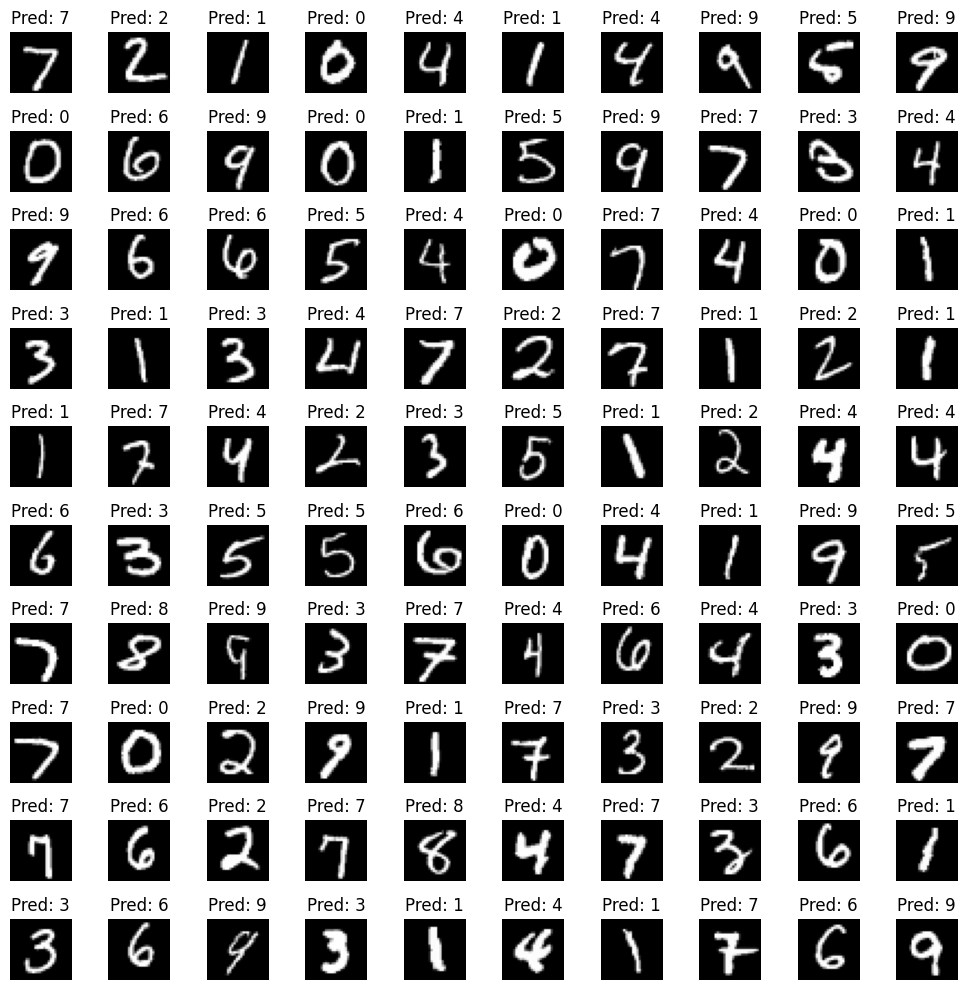

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from matplotlib import pyplot as plt

# Define your QuantizedCNN model
class QuantizedCNN(nn.Module):
    def __init__(self, num_classes=2, input_size=(1, 28, 28)):
        super(QuantizedCNN, self).__init__()
        self.num_classes = num_classes

        # Define the convolutional layers and pooling layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Initialize the features to pass a dummy input through to find number of feature outputs
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            dummy_output = self.features(dummy_input)
            num_ftrs = dummy_output.numel() // dummy_output.size(0)  # Calculate total feature number dynamically

        # Redefine the classifier part of the network
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Function to evaluate the model and calculate accuracy
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import torchvision.transforms as T
BIGGER = 28
transform_val = T.Compose([T.Resize((BIGGER, BIGGER)),
                                      T.ToTensor(),
                                      T.Normalize([0.4819], [0.1484]),
                                    #   ConvertToRGB()
                                      ])

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform_val, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model and load trained weights
model = QuantizedCNN(num_classes=10, input_size=(1, BIGGER, BIGGER)).to(device)
model.load_state_dict(torch.load('checkpoint/KD_MNISTresnet18==>smaller_qt.pt', map_location=device))


# Function to visualize 100 images with their predicted labels
def visualize_predictions(model, dataloader):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(10, 10))
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(images.size(0)):
                if images_shown >= 100:
                    break
                
                image = images[i].cpu().squeeze(0)  # Remove the channel dimension
                predicted_label = predicted[i].item()
                
                plt.subplot(10, 10, images_shown + 1)
                plt.imshow(image, cmap='gray')
                plt.title(f'Pred: {predicted_label}')
                plt.axis('off')
                
                images_shown += 1
            
            if images_shown >= 100:
                break

    plt.tight_layout()
    plt.show()

    
# Visualize predictions
visualize_predictions(model, test_loader)

# Count number of parameters

In [1]:
import torch
import torch.nn as nn
from torchvision import models

# Load the pre-trained ResNet50 model
resnet50 = models.resnet50(weights='IMAGENET1K_V1')

# Modify the last fully connected layer to match 2 output classes
# ResNet50's last layer (fc) has 2048 input features, we replace it for 2 classes
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 2)

# Check the number of parameters
total_params = sum(p.numel() for p in resnet50.parameters())
trainable_params = sum(p.numel() for p in resnet50.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 23512130
Trainable parameters: 23512130


In [3]:
import torch
import torch.nn as nn
from torchvision import models

# Load the pre-trained ResNet50 model
resnet50 = models.resnet18(weights='IMAGENET1K_V1')

# Modify the last fully connected layer to match 2 output classes
# ResNet50's last layer (fc) has 2048 input features, we replace it for 2 classes
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 2)

# Check the number of parameters
total_params = sum(p.numel() for p in resnet50.parameters())
trainable_params = sum(p.numel() for p in resnet50.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mdi220/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s] 


Total parameters: 11177538
Trainable parameters: 11177538
